# CNN autoencoder metrics

In [1]:
# load custom packages from src dir
import sys
sys.path.insert(0, '..')

# python packages
import logging
import os
import numpy as np
import torch

# Viz
import matplotlib.pyplot as plt
%matplotlib inline

# custom packages
import src.commons.constants as cons

# U-Net custom implementation
from src.models.u_net import *

# Define the logging level
logging.getLogger().setLevel(logging.INFO)

## Load the model

In [2]:
CHECKPOINT_PATH = ".." + cons.DIR_SEP + os.path.join("results")
CHECKPOINT_PATH = os.path.join(CHECKPOINT_PATH, 'autoencoder_models')
CATEGORY = 'tile'
resize_dim = 200
PATH = os.path.join(CHECKPOINT_PATH, f"autoencoder_{CATEGORY}_resizedim_{resize_dim}.pt")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load the model
model = SegmentationNetwork(n_channels=3, n_classes=3).to(DEVICE)
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## Load the test data

In [3]:
test_data = load_test_data(CATEGORY, batch_size=4)
test_data

{'dataset': <src.commons.dataset.MVTECTestDataset at 0x1293194e0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x109fee8c0>}

## Model predictions

In [4]:
inputs, recons, targets = predict(model, test_data['test'], resize_dim=resize_dim)

100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


## Metrics

In [5]:
import src.commons.internal_metrics as i_metrics

In [6]:
inputs_resh = einops.rearrange(inputs, "n b c h w -> (n b) h w c")
recons_resh = einops.rearrange(recons, "n b c h w -> (n b) h w c")
targets_resh = einops.rearrange(targets, "n b c h w -> (n b) h w c")

In [7]:
def get_pixel_level_metrics(inputs, recons, targets, idx, threshold=0.5):
    scores = np.sqrt(((inputs[idx] - recons[idx])**2).sum(-1)) # anomaly mask
    scores = (scores - scores.min())/(scores.max() - scores.min()) # Normalize scores
    fpr = i_metrics.get_fpr(y_true=targets[idx][:,:,0], y_score=scores, threshold=threshold)
    prc = i_metrics.get_prc(y_true=targets[idx][:,:,0], y_score=scores, threshold=threshold)
    iou = i_metrics.get_iou(y_true=targets[idx][:,:,0], y_score=scores, threshold=threshold)
    return {'fpr': fpr.numpy()*1, 'prc': prc.numpy()*1, 'iou': iou.numpy()*1}


def get_region_level_metrics(inputs, recons, targets, idx, threshold=0.5):
    scores = np.sqrt(((inputs[idx] - recons[idx])**2).sum(-1)) # anomaly mask
    scores = (scores - scores.min())/(scores.max() - scores.min()) # Normalize scores
    pro = i_metrics.get_pro(y_true=targets[idx][:,:,0], y_score=scores, threshold=threshold)
    return {'pro': pro}


def get_threshold_independent_metrics(inputs, recons, targets, idx):
    scores = np.sqrt(((inputs[idx] - recons[idx])**2).sum(-1)) # anomaly mask
    scores = (scores - scores.min())/(scores.max() - scores.min()) # Normalize scores
    scores = scores.numpy()
    gt_mask = targets[idx][:,:,0].numpy()
    gt_mask = np.where(gt_mask > 0.5, 1, 0)
    mroc = i_metrics.fpr_pro_iou_curves(y_true=gt_mask, y_score=scores)
    return {'mroc': mroc}


def get_plot(inputs, recons, targets, idx, threshold=0.5):
    scores = np.sqrt(((inputs[idx] - recons[idx])**2).sum(-1)) # anomaly mask
    scores = (scores - scores.min())/(scores.max() - scores.min()) # Normalize scores
    score_bin = np.where(scores > threshold, 1, 0) # Threshold scores
    fig, axs = plt.subplots(1, 5, figsize=(8, 8))
    axs[0].imshow(inputs[idx])
    axs[0].set_title('Raw image')
    axs[0].axis('off')
    axs[1].imshow(recons[idx])
    axs[1].set_title('Generated image')
    axs[1].axis('off')
    axs[2].imshow(scores, cmap="Greys_r")
    axs[2].set_title('Score map')
    axs[2].axis('off')
    axs[3].imshow(score_bin, cmap="Greys_r")
    axs[3].set_title('Score map binary')
    axs[3].axis('off')
    axs[4].imshow(targets[idx])
    axs[4].set_title('Target')
    axs[4].axis('off')
    fig.tight_layout()
    plt.show()

In [9]:
idx = 1
threshold = 0.5

In [10]:
pixel_level_results = get_pixel_level_metrics(inputs_resh, recons_resh, targets_resh, idx, threshold=threshold)
pixel_level_results

{'fpr': 0.002170582301914692,
 'prc': 0.5355191230773926,
 'iou': 0.10594594478607178}

In [11]:
region_level_results = get_region_level_metrics(inputs_resh, recons_resh, targets_resh, idx, threshold=threshold)
region_level_results

{'pro': 0.11666666666666667}

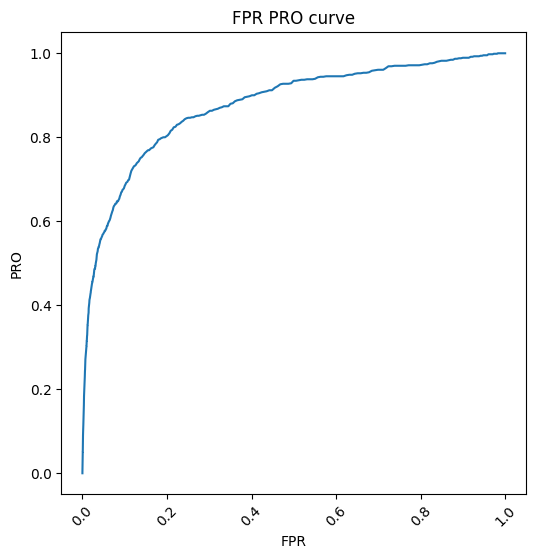

In [13]:
%%time
thrs_ind_results = get_threshold_independent_metrics(inputs_resh, recons_resh, targets_resh, idx)

mroc_py = thrs_ind_results['mroc']

plt.figure(figsize=(6,6))
plt.plot(mroc_py['fpr'], mroc_py['pro'])
plt.xticks(rotation=45)
plt.title('FPR PRO curve')
plt.xlabel('FPR')
plt.ylabel('PRO')
plt.show()

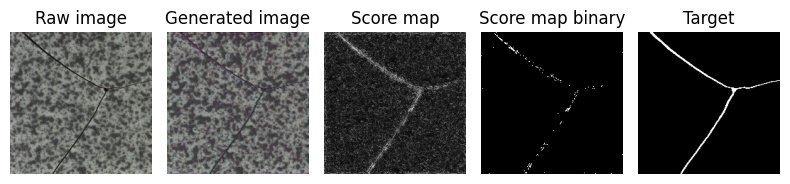

In [14]:
threshold = 0.5
get_plot(inputs_resh, recons_resh, targets_resh, idx, threshold=threshold)
    